<p style="text-align:center; font-size:20px; font-weight:700; font-family: monospace; background-color:rgb(50,50,50); color:rgb(0,255,0); padding:1vh 1vw; border:hidden; border-radius:3px">Projeto 3 - Ciência dos Dados</p>

Alunos:
<ul style="font-family:monospace">
    <li>Cicero Tiago Carneiro Valentim</li>
    <li>Luiz Felipe Lazzaron</li>
    <li>Marcos Vinícius da Silva</li>
    <li>Thalia Loiola Silva</li>
</ul>

In [1]:
# pandas # (comentar)
import pandas as pd 
from pandas.tools.plotting import scatter_matrix 

# numpy # (comentar)
import numpy as np 

# matplotlib #(comentar)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 

# (comentar)
import seaborn as sns

# time (calular tempo gasto nos modelos)
from time import time

# warnings (deixar de poluir o documento com warnings)
import warnings
warnings.filterwarnings('ignore')

# scikit-learn (comentar)
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer, StandardScaler, Imputer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error
try:
    from sklearn.compose import ColumnTransformer
except ImportError:
    from future_encoders import ColumnTransformer # Scikit-Learn < 0.20

# scikit-learn modelos (comentar)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# função utilizada para exibir os scores dos modelos
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

# classe criada para auxiliar as transformações na pipeline
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

%matplotlib inline 

In [2]:
airbnb = pd.read_csv("AB_NYC_2019.csv")

In [3]:
airbnb.head(2)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355


In [4]:
# limpar colunas desnecessárias:
airbnb = airbnb.drop(columns=["id","name","host_name","minimum_nights","last_review", 'reviews_per_month', 'calculated_host_listings_count', 'host_id'])

In [5]:
# analisar a coluna "room_type", pois ela parece ser relevante para a análise
airbnb["room_type"].value_counts() # Essa coluna mostrou bastante potencial como variável qualitativa

Entire home/apt    25409
Private room       22326
Shared room         1160
Name: room_type, dtype: int64

In [6]:
airbnb.head(2)

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,number_of_reviews,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,9,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,45,355


### Separação em teste e treinamento

In [7]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(airbnb, airbnb["room_type"]):
    strat_train_set = airbnb.loc[train_index] # x_train
    strat_test_set = airbnb.loc[test_index] # x_test
    y_test = airbnb["room_type"][test_index] #y_train

In [8]:
strat_test_set.head(2)

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,number_of_reviews,availability_365
15603,Brooklyn,Bushwick,40.70076,-73.92371,Private room,50,0,0
5781,Brooklyn,Crown Heights,40.67658,-73.94440,Private room,100,0,83


In [9]:
strat_train_set.head(2)

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,number_of_reviews,availability_365
12776,Brooklyn,Williamsburg,40.71602,-73.96248,Entire home/apt,130,67,252
38717,Manhattan,Tribeca,40.71519,-74.00654,Entire home/apt,312,0,38


In [10]:
airbnb = strat_train_set.drop("price", axis=1)  # df para treinamento
airbnb_labels = strat_train_set["price"].copy() # "gabarito"

In [11]:
airbnb_labels.head()

12776    130
38717    312
35008    150
266       60
38787     75
Name: price, dtype: int64

In [12]:
airbnb.head(2)

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,number_of_reviews,availability_365
12776,Brooklyn,Williamsburg,40.71602,-73.96248,Entire home/apt,67,252
38717,Manhattan,Tribeca,40.71519,-74.00654,Entire home/apt,0,38


In [13]:
airbnb.shape, airbnb_labels.shape

((39116, 7), (39116,))

In [14]:
# where magic happens
num_attribs = list(airbnb.drop(columns=["neighbourhood_group","neighbourhood","room_type"]).columns)
cat_attribs = ["neighbourhood_group","neighbourhood","room_type"]

num_pipeline = Pipeline([
    ( 'selector', DataFrameSelector(num_attribs) ),
    ('imputer', SimpleImputer(strategy="median")),
    ( 'std_scaler', StandardScaler() )
])
cat_pipeline = Pipeline([
    ( 'selector', DataFrameSelector(cat_attribs) ),
    ( 'label_encoder', LabelEncoder())
])
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
])

In [15]:
airbnb_prepared = full_pipeline.fit_transform(airbnb)

In [16]:
some_data = airbnb.iloc[:5] # analise das 8 primeiras linhas

In [17]:
some_data

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,number_of_reviews,availability_365
12776,Brooklyn,Williamsburg,40.71602,-73.96248,Entire home/apt,67,252
38717,Manhattan,Tribeca,40.71519,-74.00654,Entire home/apt,0,38
35008,Manhattan,West Village,40.73202,-74.00348,Private room,2,56
266,Brooklyn,Williamsburg,40.70690,-73.95467,Private room,14,362
38787,Brooklyn,Bedford-Stuyvesant,40.69054,-73.92801,Entire home/apt,4,10


In [18]:
some_labels = airbnb_labels.iloc[:5]

In [19]:
some_data_prepared = full_pipeline.transform(some_data)

In [20]:
some_data_prepared_1 = full_pipeline.transform(airbnb)

In [21]:
some_data_prepared_1

<39116x230 sparse matrix of type '<class 'numpy.float64'>'
	with 273812 stored elements in Compressed Sparse Row format>

<hr><p style="text-align:center; font-size:20px; font-weight:700; font-family: monospace">K-Neighbors Regressor</p><hr>

Esse tipo de algoritmo pode ser utilizado tanto para classificações como para regressões. Nesse caso, como o próprio título já sugere, o modelo será focado em uma regressão, de tal forma que se consiga prever o preço de determinada residência tomando como base em uma medida de similaridade.

In [22]:
from sklearn.neighbors import KNeighborsRegressor
import mglearn 

In [23]:
time_init = time()

k_reg = KNeighborsRegressor(n_neighbors=5)
k_reg.fit(airbnb_prepared, airbnb_labels)

print("\nTempo gasto: {:.2f} segundos".format(time() - time_init))


Tempo gasto: 0.03 segundos


In [24]:
print("Predictions:\t", list(k_reg.predict(some_data_prepared)))
print("Labels:\t\t", list(some_labels))

Predictions:	 [173.8, 586.2, 108.6, 268.2, 109.6]
Labels:		 [130, 312, 150, 60, 75]


In [25]:
airbnb_predictions = k_reg.predict(airbnb_prepared)

In [27]:
time_init = time()

log_rmse_scores = cross_val_score(k_reg, airbnb_prepared, airbnb_labels,
                             scoring="neg_mean_squared_error", cv=10)

print("\nTempo gasto: {:.2f} segundos".format(time() - time_init))


Tempo gasto: 68.43 segundos


In [28]:
display_scores(log_rmse_scores)

Scores: [-40173.69976483 -54746.98580777 -69472.25307771 -78542.26161554
 -69005.90395706 -60668.47939673 -63556.05862439 -56248.05295832
 -33306.06145743 -53397.87012017]
Mean: -57911.762677994906
Standard deviation: 12942.327211024216


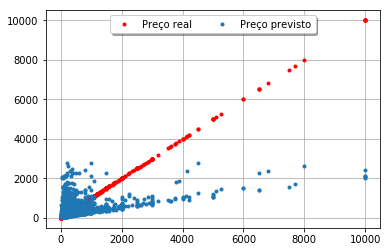

In [29]:
ax = plt.subplot(111)
plt.plot(airbnb_labels, airbnb_labels, 'r.', label='Preço real')
plt.plot(airbnb_labels, airbnb_predictions, '.', label='Preço previsto')
plt.grid(True)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.00), shadow=True, ncol=2)
plt.show()